# Load all notebooks with Functions

In [139]:
%run ../Functions/Functions_Finalized.ipynb

# Configure Parameters

In [140]:
# PARAMETERS

ATTRIBUUT = "ndFreeOfAlcohol" # Select your target attribut                                          
numerieke_features = []# not used for FreeOfAlcohol

SAVE_MODEL = False #True # Wil je een oud model overschrijven met een nieuwe?
EPOCHS = 500

Classes_threshold = 11
Overig_threshold = 200 # Class beneden deze threshold, zal worden toegevoegd aan class: 'overig'

Upsample_size_TRAIN = 4000
Upsample_size_VAL = 1000
Upsample_size_TEST = 1000

balance_threshold_single_label = 100
upsample_single_label = 0

downsampeling_needed = False

# Training Process loop

Downsamepling gebruiken als je een attribuut hebt die hele ongebalanceerde classes hebt (bijv. 5000 True, 5000 False en 20000 Empty), alles wordt dan even groot als de kleinste class (equal_classes_downsample). Als dit niet nodig is dan gebruik je imbalance_check_single_label. Zet boolean downsampeling_need op True in cmd 5 indien gewenst.

   index  ndFreeOfAlcohol
0   True              300
1  False              300
ATTRIBUUT:  ndFreeOfAlcohol
['False', 'True']
['False', 'True']


,gtin,gln,ndFreeOfAlcohol,False,True,Aantal_classes,class_num_ndFreeOfAlcohol,class_names_ndFreeOfAlcohol
0,4;06057E+12,4;06057E+12,True,0,1,1,"[0, 1]","[False, True]"
1,4;06057E+12,4;06057E+12,True,0,1,1,"[0, 1]","[False, True]"
2,4;06057E+12,4;06057E+12,True,0,1,1,"[0, 1]","[False, True]"
3,4;06057E+12,4;06057E+12,True,0,1,1,"[0, 1]","[False, True]"
4,96199510,5;03886E+12,True,0,1,1,"[0, 1]","[False, True]"
...,...,...,...,...,...,...,...,...
595,8;71755E+12,8;71242E+12,False,1,0,1,"[1, 0]","[False, True]"
596,8;71755E+12,8;71242E+12,False,1,0,1,"[1, 0]","[False, True]"
597,8;71795E+12,8;71242E+12,False,1,0,1,"[1, 0]","[False, True]"
598,8;71795E+12,8;71242E+12,False,1,0,1,"[1, 0]","[False, True]"


{'False': 300, 'True': 300}


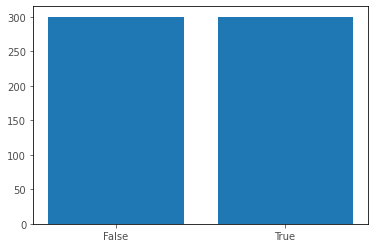

null entries =  0
Vocab size:  2929.0
Vocabular size:  2929.0
Numerical Features:  Index([], dtype='object')
Shape Numerical Features:  (600, 0)
Shape Text Features:  (600, 210)
Shape Targets:  (600, 2)
type xtrain: <class 'numpy.ndarray'>
(420, 2) (90, 2) (90, 2)
(420, 2) (90, 2) (90, 2)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [141]:
# Formateer
#nd_controle = pd.read_csv('../dataset/NLP_processed.csv', sep=';')
nd_controle = pd.read_pickle('../dataset/NLP_processed_noEmpty.pkl')
padded_sequences = nd_controle['padded_seq_'].tolist()

nd_controle[ATTRIBUUT] = nd_controle[ATTRIBUUT].fillna('EMPTY')
nd_controle = nd_controle.astype({ATTRIBUUT: str})
DF_merged, multi_label_flag,classes_available = create_overige_class(nd_controle, ATTRIBUUT,Classes_threshold, Overig_threshold)

#Prepare for trainimg
#DF_merged = pd.merge(DF_merged, padded_sequences, how="left")
DF_merged['padded_seq_'] = padded_sequences
#display(DF_merged)
vocab_size = get_vocabulary_size(DF_merged)

if multi_label_flag == True:
    X_train, X_val, X_test, y_train, y_val, y_test, targets = total_split(DF_merged, numerieke_features, ATTRIBUUT)
else:
    if downsampeling_needed == True:
        DF_merged = equal_classes_downsample(classes_available, DF_merged)
    else:
        DF_merged = imbalance_check_single_label(classes_available, DF_merged, upsample_single_label)
    ytrain, yval, ytest, Xtrain_num, Xtrain_text, Xval_num, Xval_text, Xtest_num, Xtest_text = single_prep(numerieke_features, DF_merged, ATTRIBUUT)

In [142]:
if multi_label_flag == True:
    classes = DF_merged['overig'].value_counts().index.tolist() # haal [0,1] en [1,0] als class eruit
    X_train, y_train = balance_multi_label(targets, y_train, X_train, classes, Upsample_size_TRAIN, balance_set = "TRAIN-SET") # Balance each sub-class TRAINING
    X_val, y_val = balance_multi_label(targets, y_val, X_val, classes, Upsample_size_VAL, balance_set = "VALIDATION-SET") # Balance each sub-class VALIDATION
    X_test, y_test = balance_multi_label(targets, y_test, X_test, classes, Upsample_size_TEST, balance_set = "TEST-SET") # Balance each sub-class TEST

    train_accuracies, val_accuracies, train_loss, val_loss,class_names, model = TRAINING_multi_label(X_train, X_val, X_test, y_train, y_val, y_test, numerieke_features, vocab_size, ATTRIBUUT, SAVE_MODEL) # Start training the model --> Multi label
else:
    model, model_history = TRAINING_single_label(Xtrain_num, Xtrain_text, Xval_num, Xval_text, Xtest_num, Xtest_text, vocab_size, EPOCHS, SAVE_MODEL)


**************** SINGLE LABEL MODEL ***************

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 210)]        0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 210, 4)       11716       input_42[0][0]                   
__________________________________________________________________________________________________
flatten_20 (Flatten)            (None, 840)          0           embedding_20[0][0]               
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, 0)]          0                                            
______________________________________

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
3/3 [==============================] - 0s 11ms/step - loss: 0.3514 - accuracy: 0.9000
unique amount of classes:  2 [0, 1]


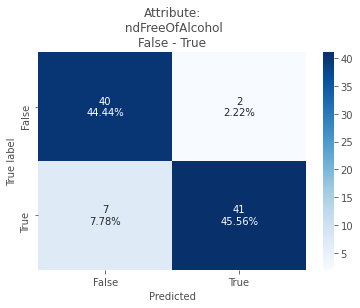

Confusion Matrix:
**************************
  [[40  2]
 [ 7 41]] 
**************************

Accuracy:  90.0
Classification report:                precision    recall  f1-score   support

           0       0.85      0.95      0.90        42
           1       0.95      0.85      0.90        48

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.91      0.90      0.90        90

[0.8999876527966415]


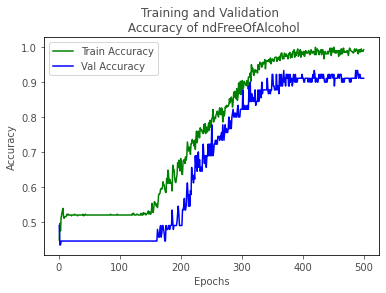

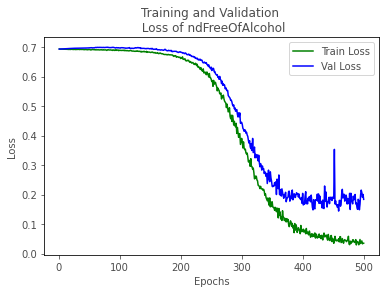

In [143]:
# Plot statistieken van de training fase
if multi_label_flag == True:
    plot_multiple_training(train_accuracies, val_accuracies, class_names, ATTRIBUUT, type_='Accuracy')
    plot_multiple_training(train_loss, val_loss, class_names, ATTRIBUUT, type_='Loss')
else:
    plot_single_label_training(model, model_history, Xtest_num, Xtest_text, ytest, ATTRIBUUT, DF_merged)
    